<a href="https://colab.research.google.com/github/bbcndoro/bigData/blob/kris/praktikumPysparkDataSuara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Instal PySpark (biasanya cukup ini di Colab)
!pip install pyspark --quiet

from pyspark.sql import SparkSession

# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("AudioFeaturesAnalysis") \
    .getOrCreate()

spark


In [30]:
import os
import requests

# URL RAW dataset di GitHub
data_url = "https://raw.githubusercontent.com/Maz-Codes/audio-feature-extraction/main/audio_features.csv"

local_path = "/tmp/audio_features.csv"

try:
    if not os.path.exists(local_path):
        print("Mengunduh dataset dari web...")
        resp = requests.get(data_url)
        resp.raise_for_status()  # akan error kalau 404 / 500

        with open(local_path, "wb") as f:
            f.write(resp.content)

        print("File tersimpan di:", local_path)
    else:
        print("File sudah ada:", local_path)

except Exception as e:
    print("Gagal mengunduh file:", e)


File sudah ada: /tmp/audio_features.csv


In [31]:
import pandas as pd

# URL RAW dataset (tetap sama seperti sebelumnya)
data_url = "https://raw.githubusercontent.com/Maz-Codes/audio-feature-extraction/main/audio_features.csv"

# Baca dengan pandas dulu
pdf = pd.read_csv(data_url)

print("Ukuran data (baris, kolom):", pdf.shape)
print("5 baris pertama (pandas):")
display(pdf.head())

# Konversi pandas DataFrame -> Spark DataFrame
df = spark.createDataFrame(pdf)

print("Jumlah baris di Spark:", df.count())
df.printSchema()
df.show(5, truncate=False)


Ukuran data (baris, kolom): (1, 62)
5 baris pertama (pandas):


,file_name,duration,tempo,harmonic_ratio,spectral_centroid_mean,spectral_centroid_std,spectral_rolloff_mean,spectral_rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,chroma_8_mean,chroma_8_std,chroma_9_mean,chroma_9_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_12_mean,chroma_12_std
0,sample.wav,5.0,198.768029,0.851932,2244.264651,403.523239,5049.88505,993.977131,0.060588,0.02132,...,0.39649,0.20012,0.535346,0.276167,0.572412,0.267602,0.663616,0.166011,0.880203,0.177306


Jumlah baris di Spark: 1
root
 |-- file_name: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- harmonic_ratio: double (nullable = true)
 |-- spectral_centroid_mean: double (nullable = true)
 |-- spectral_centroid_std: double (nullable = true)
 |-- spectral_rolloff_mean: double (nullable = true)
 |-- spectral_rolloff_std: double (nullable = true)
 |-- zero_crossing_rate_mean: double (nullable = true)
 |-- zero_crossing_rate_std: double (nullable = true)
 |-- spectral_bandwidth_mean: double (nullable = true)
 |-- spectral_contrast_mean: double (nullable = true)
 |-- mfcc_1_mean: double (nullable = true)
 |-- mfcc_1_std: double (nullable = true)
 |-- mfcc_2_mean: double (nullable = true)
 |-- mfcc_2_std: double (nullable = true)
 |-- mfcc_3_mean: double (nullable = true)
 |-- mfcc_3_std: double (nullable = true)
 |-- mfcc_4_mean: double (nullable = true)
 |-- mfcc_4_std: double (nullable = true)
 |-- mfcc_5_mean: double (nullable =

In [32]:
from pyspark.sql.types import NumericType

# Ambil semua kolom numerik dari DataFrame Spark
numeric_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, NumericType)
]

print("Contoh kolom numerik:", numeric_cols[:15])

# Pilih hanya kolom numerik
df_features = df.select(*numeric_cols)

# Statistik deskriptif dasar
df_features.describe().show()

import matplotlib.pyplot as plt

# Ambil sampel 10% untuk visualisasi
pdf_feat = df_features.sample(False, 0.1, seed=42).toPandas()
print(pdf_feat.shape)


Contoh kolom numerik: ['duration', 'tempo', 'harmonic_ratio', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_std', 'spectral_bandwidth_mean', 'spectral_contrast_mean', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std']
+-------+--------+------------------+--------------+----------------------+---------------------+---------------------+--------------------+-----------------------+----------------------+-----------------------+----------------------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+------------+-----------+------------+-----------+------------+-----------+------------+-----------+-------------+------------+-------------+------------+-------------+------------+-------------+------------+-------------+-----------

Scatter: duration vs tempo


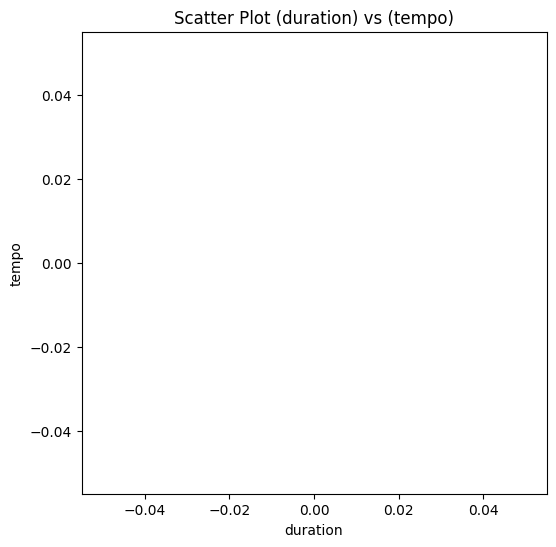

Kolom untuk boxplot: ['duration', 'tempo', 'harmonic_ratio', 'spectral_centroid_mean', 'spectral_centroid_std']


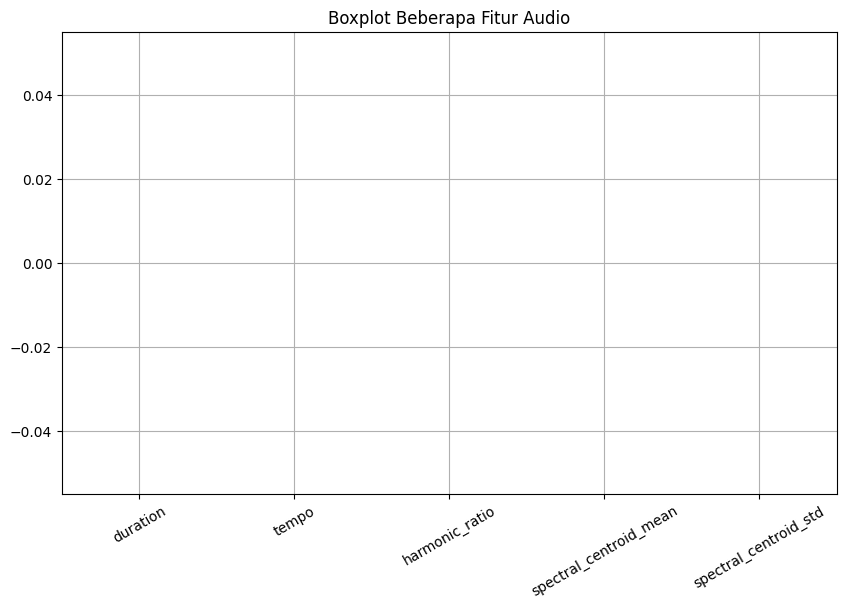

In [33]:
# Scatter plot: ambil 2 fitur numerik pertama
if len(numeric_cols) >= 2:
    x_col = numeric_cols[0]
    y_col = numeric_cols[1]
    print("Scatter:", x_col, "vs", y_col)

    plt.figure(figsize=(6, 6))
    plt.scatter(pdf_feat[x_col], pdf_feat[y_col], alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Scatter Plot ({x_col}) vs ({y_col})")
    plt.show()

else:
    print("Fitur numerik kurang dari 2.")


# Boxplot: ambil 5 fitur numerik pertama
box_cols = numeric_cols[:5]
print("Kolom untuk boxplot:", box_cols)

if box_cols:
    plt.figure(figsize=(10, 6))
    pdf_feat[box_cols].boxplot()
    plt.title("Boxplot Beberapa Fitur Audio")
    plt.xticks(rotation=30)
    plt.show()
else:
    print("Tidak ada kolom numerik untuk boxplot.")


In [39]:
from pyspark.sql.types import NumericType

# Ambil semua kolom numerik dari DataFrame Spark
numeric_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, NumericType)
]

print("Contoh kolom numerik:",len(numeric_cols))
print("Contoh kolom numerik:", numeric_cols[:10])
print("Contoh kolom numerik:", df.count())

import matplotlib.pyplot as plt

#pastikan matplotlib aktif di notebook
%matplotlib inline

# Pilih hanya kolom numerik
df_features = df.select(*numeric_cols)

# Statistik deskriptif dasar
df_features.describe().show()



# Ambil maks 500 baris untuk visualisasi
pdf_feat = df_features.limit(500).toPandas()

print("Ukuran pdf_feat", pdf_feat.shape)
print(pdf_feat.head())


Contoh kolom numerik: 61
Contoh kolom numerik: ['duration', 'tempo', 'harmonic_ratio', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_std', 'spectral_bandwidth_mean']
Contoh kolom numerik: 1
+-------+--------+------------------+--------------+----------------------+---------------------+---------------------+--------------------+-----------------------+----------------------+-----------------------+----------------------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+------------+-----------+------------+-----------+------------+-----------+------------+-----------+-------------+------------+-------------+------------+-------------+------------+-------------+------------+-------------+------------+-------------+------------+------

Scatter: duration vs tempo


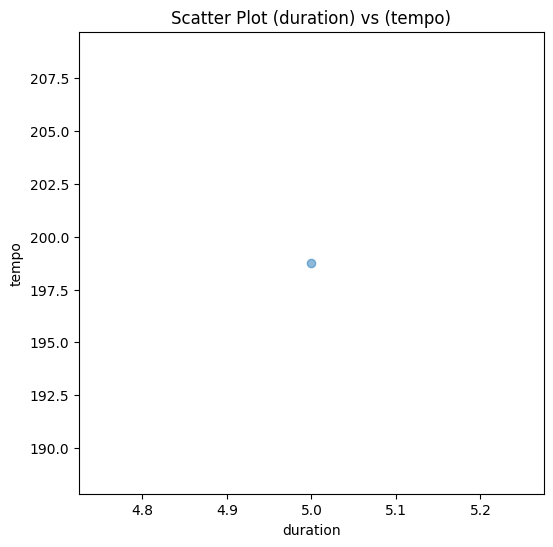

In [40]:
# === Scatter Plot ===
if len(numeric_cols) >= 2 and len(pdf_feat) > 0:
    x_col = numeric_cols[0]
    y_col = numeric_cols[1]
    print("Scatter:", x_col, "vs", y_col)

    plt.figure(figsize=(6, 6))
    plt.scatter(pdf_feat[x_col], pdf_feat[y_col], alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Scatter Plot ({x_col}) vs ({y_col})")
    plt.show()
else:
    print("Tidak cukup data/fitur untuk scatter plot.")

In [36]:
# === Boxplot (5 fitur pertama) ===
box_cols = numeric_cols[:5]
print("Kolom untuk boxplot:", box_cols)

if box_cols and len(pdf_feat) > 0:
    plt.figure(figsize=(10, 6))
    pdf_feat[box_cols].boxplot()
    plt.title("Boxplot Beberapa Fitur Audio")
    plt.xticks(rotation=30)
    plt.show()
else:
    print("Tidak ada data atau kolom numerik untuk boxplot.")

Kolom untuk boxplot: ['duration', 'tempo', 'harmonic_ratio', 'spectral_centroid_mean', 'spectral_centroid_std']
Tidak ada data atau kolom numerik untuk boxplot.


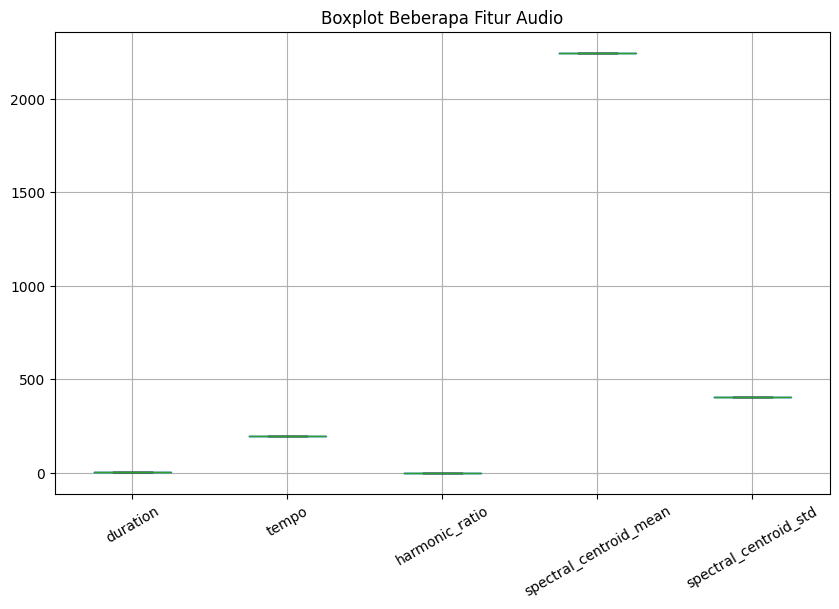

In [41]:
# (Kode boxplot kedua pada slide — sebenarnya sama)
box_cols = numeric_cols[:5]
if box_cols and len(pdf_feat) > 0:
    plt.figure(figsize=(10, 6))
    pdf_feat[box_cols].boxplot()
    plt.title("Boxplot Beberapa Fitur Audio")
    plt.xticks(rotation=30)
    plt.show()
else:
    print("Tidak ada data atau kolom numerik untuk boxplot.")

Fitur untuk histogram: duration


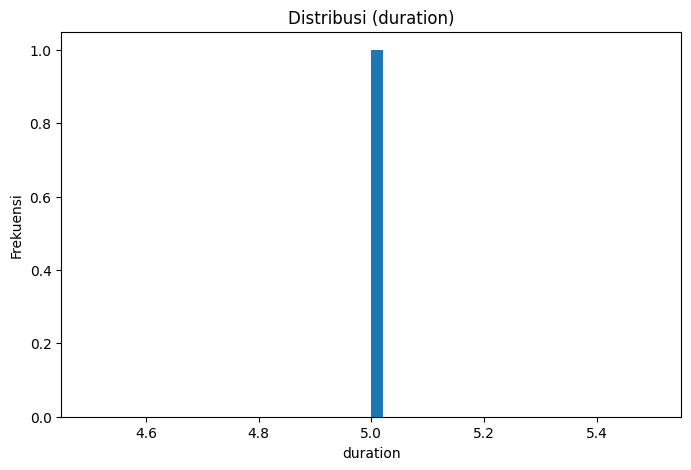

In [42]:
# === Histogram (fitur pertama) ===
if numeric_cols and len(pdf_feat) > 0:
    feature_for_hist = numeric_cols[0]
    print("Fitur untuk histogram:", feature_for_hist)

    plt.figure(figsize=(8, 5))
    plt.hist(pdf_feat[feature_for_hist].dropna(), bins=50)
    plt.xlabel(feature_for_hist)
    plt.ylabel("Frekuensi")
    plt.title(f"Distribusi ({feature_for_hist})")
    plt.show()

else:
    print("Tidak ada data/fitur untuk histogram.")